In [6]:
import numpy as np
import pandas as pd

time: 979 µs


In [7]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
time: 15.7 ms


In [8]:
%%R
library(plyr)
library(ggplot2)
library(reshape2)

time: 45 ms


In [9]:
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 10.1 ms


# TODO


Parameters for porosity in multilayer wall. 

    *endothelium 
    *tunica intima 
    *inner elastic membrane 
    *tunica media
 
Linearly interpolate diffusion parameters between Abraham at al and Jesoionek at al. to get the $D_{AB}$ for the drug in each layer.  

Does the reflectivity change per tissue? Probably right?  Different cells endocytose the drug at a greater rate.  So if we can get binding coefficients/reflection coefficients for each tissue that would be good.

We can also linearily interpolate those.

Once parameter set is stable for any number of wall models, do some testing them run fine mesh on cluster.

Compare results to default wall model and literature values presented in Abraham et al.



    


# Parameters

Multilayer models the the arterial wall taken from Jesionek 2014.

"Effects of shear stress on low-density lipoproteins (LDL) transport in the multi-layered arteries"

The class object allow us to easy access all variables.
Define constants and wall models as lists ala Jesionek.

In [23]:
class Testing_Parameters_4_Layer(object):
    """ Multi Phase testing parameters for 4 layer wall
    """
    
    # Global
    Df = 50
    vessel_radius = 2.00E3 
    dp = 4784
    
    # Variable  
    names       = [  'endothel'  , 'intima' , 'IEL'     ,'media'   ]
    L           = [   2.         , 10.      , 2.        , 200.     ]
    Dt          = [   6E-6       , 5.0e-1   , 3.18e-4   , 5e-3     ]
    epsilon     = [   5E-4       , 0.61     , 5E-4      , 0.61     ] 
    alpha       = [   1-0.9886   , 1-0.8292 , 1-0.8295  , 1-0.8660 ]
    gamma       = [   38         , 38       , 38        , 38       ] 
    K           = [   3.2172e-9  , 2.2e-4   , 3.18e-7   , 2e-6     ]
    mu          = [   0.72e-3    , 0.72e-3  , 0.72e-3   , 0.72e-3  ]
 
    # Find porosirt estimates
class Vafai_4_Layer(object):
    """ 
        L. Ai, K. Vafai,
        International Journal of Heat and Mass Transfer
        49 (2006)
        
        Had to keep the porosity (epsilon) and the p
        partition coefficient from Abraham et al.
        
        Dt is for LDL ... need to approximate it to the drug
        
            
    """
    
    # Global
    Df = 50
    vessel_radius = 2.00E3 
    dp = 9332.6
    
    # Variable  
    names       = [  'endothel'  , 'intima' , 'IEL'    ,'media'   ]
    L           = [   2.         , 10.      , 2.       , 200.     ]
    Dt          = [   8.514E-13  , 5.0E-8   , 3.18E-11 , 5.0E-10  ] # cm^2/s
    epsilon     = [   0.0005     , 0.96     , 0.004    , 0.15     ] # D'Less
    alpha       = [   1.145E-2   , 1.7084E-1, 1.7084E-1, 1.34E-1  ] # D'less 
    gamma       = [   38         , 38       , 38       , 38       ] # D'less --> from abraham 
    K           = [   3.2172e-17 , 2.2e-12  , 3.18e-15 , 2.0E-14  ] # cm^2  
    mu          = [   0.72e-3    , 0.72e-3  , 0.72e-3  , 0.72e-3  ] # g/cm^2 s
    
    # convert units
    Dt = [i * 1E8 for i in Dt]
    K  = [i * 1E8 for i in K]
    
    
    # convert to drug units
    dta = 5.0E-11 # m^2/s
    dta = dta * 1E12 # um^2/s
    print('dta: ', dta)
    # Assume the reference abraham is for the intima
    Dt_new = []
    for i in range(len(Dt)):
        Dt_new.append( Dt[i]*(dta/Dt[1]) )

    Dt = Dt_new

    
class Testing_Parameters_2_Layer(object):
    """ Multi Phase testing parameters.
    """
    
    # Global
    Df = 50
    vessel_radius = 2.00E3 
    dp = 4784
    
    # Variable
    name        = [ 'endothelium', 'wall' ]
    L           = [ 10           , 200    ] 
    Dt          = [ 5.0E-6       , 0.6    ] 
    epsilon     = [ 5E-4         , 0.61   ] 
    alpha       = [ 0.01         , 0.15   ] 
    gamma       = [ 38           , 38     ]
    K           = [ 3.2E-12      , 1.2E-6 ] 
    mu          = [ 1.0E-3       , 1.0E-3 ] 
               
class Testing_Parameters(object):
    """ Single Phase testing parameters used in Abraham et al.
    """
    
    # Global Parameters
    
    # Flux - VR
    # Diffusivity of drug in fluid
    # vessel size
    # Pressure drop
    VR = 37.5 # um^2/s?
    Df = 50 # um^2/s
    vessel_radius = 2.00E3 # um
    dp = 4784 # Pa
    
    # Parameters of multi layer wall
    # Wall thicknes (r) - L [um]
    # Diffusivity - D [um^2/s]
    # porosity - epsilon  [D'less]
    # binding - alpha (1-reflection coefficient) [D'less]
    # partition coefficient - gamma [D'less]
        
    name        = [ 'wall' ]
    L           = [ 200    ] # thickness 
    Dt          = [ 0.6    ] # Diffusivity 
    epsilon     = [ 0.61   ] # porosity [D'less]
    alpha       = [ 0.01   ] # binding coefficeint [D'less]
    gamma       = [ 38     ] # parition coefficient 
    K           = [ 1.2E-6 ] # permeability um^2
    mu          = [ 1.0E-3 ] # dynamic viscosity Pa-s
    

    

dta:  50.0
time: 122 ms


# Simulation Class

The simulation class is the work horse of the implementation.  It does a number of things:
1) takes in an arterial wall parameter model defined above
2) Descritizes the wall in radius and time, as well as parameter space across the radius
3) Solves the drug diffusion model



In [24]:
class Drug_Diffusion(object):
    def __init__(self, parameters):
        self.p = parameters
        self.t = None
        self.f = None
        
    def descritize(self, N = 1000, M=1000, total_time=1000, delivery_time = 1000, dt=None, dr=None):
        """ 
        Create spacital grids for radial direction, time, and constants based on the wall model.
        """
        
        # get the total wall length 
        self.l = np.sum(self.p.L) 
    
        # override provided N if dr is provided ...
        # TODO: this is odd behavior fix it after testing
        if dr:
            self.dr = dr
            self.N = int(self.l / self.dr)
        else:
            self.N = N
            self.dr = float(self.l) / self.N
        
        # get spacial grid
        self.r = np.linspace(self.p.vessel_radius, self.p.vessel_radius + self.l, self.N)
        
        # TODO: mind your units
        # convert to meters
        self.r = self.r 
 
        # descritize time
        self.total_time = total_time
        if dt:
            self.dt = dt
            self.M = int(total_time / dt)
        else:
            self.M = M
            self.dt = float(self.total_time) / self.M

        # store delivery time
        self.delivery_time = delivery_time
        
        # init vectors for constants that change along radial direction
        self.Dt = np.ones(self.N)
        self.epsilon = np.ones(self.N)
        self.alpha = np.ones(self.N)
        self.gamma = np.ones(self.N)
        self.mu = np.ones(self.N)
        self.K = np.ones(self.N)

        # normalize the length of each layer so the sum is over the spactial grid
        # then get thew spacial grid boundary points
        self.layers=[0]+list( np.ceil( ( self.N * ( np.cumsum(self.p.L) / self.l ) ) ).astype(np.int32) )
        
        # make vectors of constants according the parameter wall model supplied
        for i,(a,b) in enumerate(zip(self.layers[:],self.layers[1:])): 
            self.Dt[a:b] = self.p.Dt[i] 
            self.epsilon[a:b] = self.p.epsilon[i] 
            self.alpha[a:b] = self.p.alpha[i]
            self.gamma[a:b] = self.p.gamma[i]
            self.mu[a:b] = self.p.mu[i]
            self.K[a:b] = self.p.K[i]
        
    def solve(self, fluid_bc = [1,0], tissue_bc=[0,0]):
        """
        Function to solve the diffusion equation
        """
        # create tissue mesh
        t = np.zeros((self.M,self.N)) # rows are time, columns are radius
        
        # create fluid mesh
        f = np.zeros((self.M,self.N))
        
        # set the boundary condition of delivery for some time as a constant  stream of drug in the center of the fluid
        delivery_index = int(np.ceil((float(self.delivery_time) / self.total_time)* self.M))
        f[:delivery_index,0] = fluid_bc[0]
        
             
        # Loop through time and space, solving the finite differences model
        # by population the solution matricies f and t
        for i in range(1,self.M-1): # time
            for j in range(1,self.N-1): # space
                # get wall model parameters for current spacial location
                r = self.r[j]
                alpha = self.alpha[j]
                gamma = self.gamma[j]
                epsilon = self.epsilon[j]
                Dt = self.Dt[j]
                mu = self.mu[j]
                K = self.K[j]
                
                # calculate velocity
                u = K * self.p.dp / mu / np.log(( self.p.vessel_radius + self.l     ) / self.p.vessel_radius )
                
                # update fluid using equation from the paper
                f[i, j] = f[i-1,j] + \
                                        u / (epsilon * self.r[j]) * (self.dt /  self.dr) * (f[i-1,j-1] - f[i-1,j])  + \
                                        self.p.Df * self.dt / (2 * self.r[j] * self.dr**2) * ( \
                                            ( self.r[j+1] + self.r[j] ) * (f[i-1,j+1] - f[i-1,j]) - \
                                            ( self.r[j] + self.r[j-1] ) * (f[i-1,j] - f[i-1,j-1])) + \
                                        self.dt * alpha * (t[i-1,j] -  gamma * f[i-1,j] )
                            
                # update tissue
                t[i, j] = t[i-1, j] + \
                                        (Dt * self.dt)/( 2 * self.r[j] * self.dr**2 ) * ( \
                                            ( self.r[j+1] + self.r[j] ) * (t[i-1,j+1] - t[i-1,j]) - \
                                            ( self.r[j] + self.r[j-1] ) * (t[i-1,j] - t[i-1,j-1])) + \
                                        self.dt * alpha * ( gamma * f[i-1,j] - t[i-1,j])
                
            
        # store results
        self.t = t
        self.f = f
        

time: 179 ms


# Run Simulations

In [59]:
# Run default Abraham model
# Grab the appropriate parameter set
parameters = Testing_Parameters()
# initialize the simulation class with the parameters
simd = Drug_Diffusion(parameters)
# descritize as desired
simd.descritize(total_time=500, delivery_time = 25, dt=0.002, dr=1)
# run the finite differences
simd.solve()

time: 14min 37s


In [60]:
# Run testing 4 layer model
parameters = Vafai_4_Layer()
sim2 = Drug_Diffusion(parameters)
sim2.descritize(total_time=500, delivery_time = 25, dt=0.002, dr=1)
sim2.solve()

time: 12min 36s


# Testing Visualize Results

In [61]:
# Testing - get cache of data for r
# build combined data frame of default single model and 2 compartment wall model 


def my_melt(sim, fluid=True, sub_sample = True):
    # function to melt the solution matrix from a simulation
    if fluid: # if the fluid flag is set then prep the solution for the fluid matrix
        df = pd.DataFrame(sim.f)
    else: # otherwise do the tissue
        df = pd.DataFrame(sim.t) 
    
    # if we run the model with a small time step then optionally subsample the time (rows)
    # so the plotting doesn't break/take forever
    if sub_sample and (sim.dt < 1):
        df = df.iloc[::int(1/sim.dt),:]
        df.index = list(np.arange(0,sim.total_time)) # add time labels to rows
    else:
        df.index = list(np.arange(0,sim.total_time,sim.dt)) # add time labels to rows

    # add spacial column labels
    df.columns = list(np.arange(0, sim.l, sim.dr))
    # melt matrix 
    df = df.stack().reset_index() 
    # add column labels
    df.columns = ["time", "radius", "concentration"]
            
    return df

time: 21.6 ms


In [62]:
sim2.f.shape
list(np.arange(0,sim2.l, sim2.dr))
print(sim2.M, sim2.dt)
print(sim2.N, sim2.dr)
print(sim2.f.shape)


250000 0.002
214 1
(250000, 214)
time: 7.92 ms


Prep data for R 

In [63]:

# get melted versions of solution matrix 
default_f = my_melt(simd, fluid=True)
default_t = my_melt(simd, fluid=False)
multi_f = my_melt(sim2, fluid=True)
multi_t = my_melt(sim2, fluid=False)

# add wall model identifiers to the dataframes
default_f['model'] = "default"
default_t['model'] = "default"
multi_f['model'] = "multi"
multi_t['model'] = "multi"

# add fluid/tissue identifier
default_f['medium'] = "fluid"
default_t['medium'] = "tissue"
multi_f['medium'] = "fluid"
multi_t['medium'] = "tissue"

# make a list of the resulting data frames
frames = [default_f, default_t, multi_f, multi_t]

# combine all the results into one dataframe
data = pd.concat(frames)

# get some parameters into the name space so we can pass then to R
total_time = simd.total_time
N = simd.N
M = simd.M
delivery_time = simd.delivery_time

time: 190 ms


Push data to R and make some plots

In [64]:
%Rpush N M total_time data delivery_time

time: 4.6 s


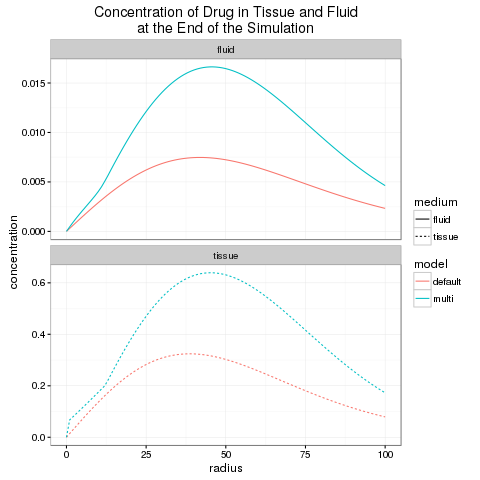

time: 291 ms


In [65]:
%%R

# get concentration in the radius for just last time point 
df = subset(data, data$time == max(data$time))

# plot the concentration as a function of radius
g = ggplot(df, aes( x=radius,
                    y=concentration,
                    linetype=medium,
                    color=model))+
    geom_line()+
    facet_wrap(~medium, scales="free_y", ncol=1)+
    theme_bw()+xlim(0,100)+
    labs(title="Concentration of Drug in Tissue and Fluid\nat the End of the Simulation")
    

print(g)

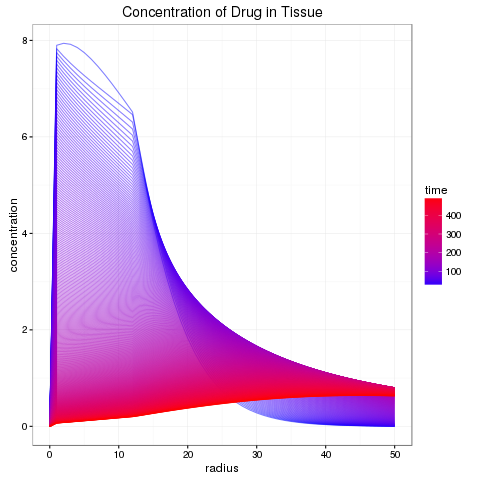

time: 1.12 s


In [66]:
%%R

# subset data to just the tissue and multicomparment model
df = subset(data, data$medium=="tissue")
df = subset(df, df$model=="multi")
# add a column for during or post drug delivery
df$delivery = 'No'
df$delivery[df$time<delivery_time]="Yes"

# subset to only after delivery times
df = subset(df, df$delivery == "No")

# make plot of drug across radius for a bunch of times
g = ggplot(df, aes( x=radius,
                    y=concentration,
                    group=time,
                    color=time))+
    geom_line(alpha=0.5)+
    scale_color_gradient(high="red",low="blue")+
    #facet_wrap(~delivery, scales="free", ncol=1)+
    theme_bw()+xlim(0,50)+#ylim(0,3)+
    labs(title="Concentration of Drug in Tissue")
    

print(g)


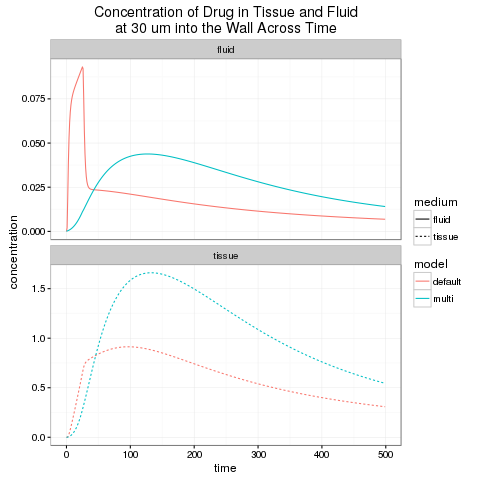

time: 298 ms


In [67]:
%%R

df = subset(data, data$radius == 30)

g = ggplot(df, aes( x=time,
                    y=concentration,
                    linetype=medium,
                    color=model))+
    geom_line()+
    facet_wrap(~medium, scales="free_y", ncol=1)+
    theme_bw()+
    labs(title="Concentration of Drug in Tissue and Fluid\nat 30 um into the Wall Across Time")
    
print(g)

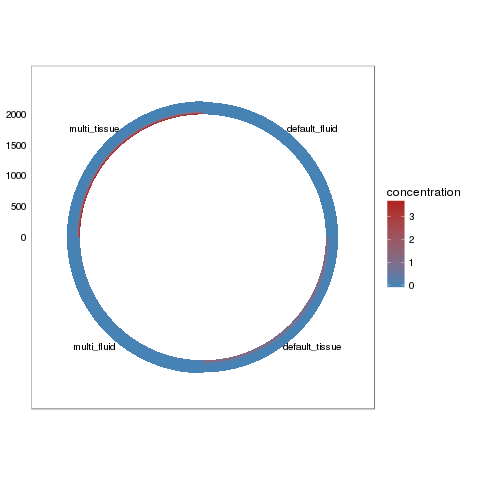

time: 4.49 s


In [58]:
%%R

df = subset(data, data$time == 99)
df$group = paste(df$model, df$medium, sep="_")
#df = subset(df, df$model == "multi")
#df = subset(df, df$medium == "Tissue")
df$radius = 2000 + df$radius


g = ggplot(df, aes( y=radius,
                    x=group,
                    fill=concentration))+
    geom_tile()+
    theme_bw()+
    ylim(c(0,max(df$radius)+20))+
    coord_polar(theta="x")+
    scale_fill_gradient(low="steelblue",high="firebrick")+
    theme(panel.background=element_blank(),
           axis.title=element_blank(),
           panel.grid=element_blank(),
           #axis.text.x=element_blank(),
           axis.ticks=element_blank())
    
print(g)